# Coursework - Team Untitled

## Team Members

| Name | Main Contribution |
| :-: | :-: |
| Ji Yikun | |
| Wang Shuqi | |
| Chen Qi | |

## Setup

All codes are tested and run under **Termux**, an Android port of Linux Debian, as a virtual environment. You may need to edit paths and some `os` commands so as to setup everything ready on Windows and other platforms.

All packages come native in *Anaconda*, but you should refer to `requirements.txt` to see if everything is set to be the right version.

## Open-source License

This notebook and its code, illustrations, are under the **MIT** License.

```
MIT License

Copyright (c) 2021 Kunologist, Wang Shuqi and Chen Qi

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.
```

## Basic: MNIST

[MNIST](http://yann.lecun.com/exdb/mnist/) is an image classification dataset of recognizing digits. This part is a simple attempt to use basic convolutional neural networks to train a model for recognizing handwritten digits.

### Import and Environment Settings

> You may wish to edit several variables here before running.

In [2]:
import os

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torchvision import datasets, transforms

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib
%matplotlib inline
mpl.rcParams['figure.dpi']=400
%config InlineBackend.figure_format = 'svg'

device = "cpu"
rootdir = os.environ['HOME'] + '/pytorch'
workdir = "/storage/emulated/0/Kunologist/Jupyter/LectureNotes/PROJECT_MNIST/"

### Set CNN

The following code use a simple convolutional neural network to identify the digit.

#### function `Net.__init__()`

> **Summary:** Defines the key networks in the `Net`, which is then used in `forward()`.

> **Returns:** Nothing (Constructor).

| Argument | Type | Description |
| :-- | :-- | :-- |
| `self` | `Net` | An instance of `Net` |

#### function `Net.forward()`

> **Summary:** Predicts the digit of the image with respect to the given input `x`.

> **Returns:** An output `Tensor` containing the softmax-ed output neurons.

| Argument | Type | Description |
| :-- | :-- | :-- |
| `self` | `Net` | An instance of `Net` |
| `x` | `` | The data of the image |

In [3]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

### Defining Sub-functions

#### function `train()`

> **Summary:** Trains the model instance with the given train loader.

> **Returns:** Nothing.

| Argument | Type | Description |
| :-- | :-- | :-- |
| `model` | `Net` | An instance of `Net` |
| `device` | `torch.device` | Where to train the model |
| `train_loader` | `torch.DataLoader` | The `DataLoader` which contains the data source of the images |
| `optimizer` | `torch.optim.*.*` | The optimizer, AdaDelta in this case |
| `epoch` | `int` | The number of epoch |

#### function `test()`

> **Summary:** Tests the model (without learning) and prints the accuracy information.

> **Returns:** Nothing.

| Argument | Type | Description |
| :-- | :-- | :-- |
| `model` | `Net` | An instance of `Net` |
| `device` | `torch.device` | Where to train the model |
| `test_loader` | `torch.DataLoader` | The `DataLoader` which contains the data source of the images |

In [4]:
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 20 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item())
            )

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(test_loss, correct, len(test_loader.dataset), 100. * correct / len(test_loader.dataset)))

### Runner

We use the standard PyTorch model training flow:

1. DataLoader for both training and testing
2. Optimizer using [AdaDelta](https://pytorch.org/docs/stable/generated/torch.optim.Adadelta.html), a more adaptive alternative to AdaGrad
3. Scheduler

One thing

In [9]:
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST(
        workdir,
        train=True,
        download=True,
        transform=transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.1307, ), (0.3081, ))
        ])
    ),
    batch_size=64,
    shuffle=True
)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST(
        workdir,
        train=False,
        transform=transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.1307, ), (0.3081, ))
        ])),
    batch_size=1000,
    shuffle=True
)

model = Net().to(device)
optimizer = optim.Adadelta(model.parameters()) # Defaults to learning rate = 1.0 and epsilon = 1e-6
scheduler = StepLR(optimizer, step_size=1, gamma=0.7)

In [ ]:
for epoch in range(1, 5 + 1):
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)
    scheduler.step()

### Saving / Loading the Model

In [8]:
# Creates the directory if not found
try:
    os.mkdir(workdir + "models")
except:
    pass

# Save the model
from datetime import datetime
model_name = "models/model-" + datetime.now().strftime("%Y%m%d-%H%M%S")
torch.save(model, workdir + model_name)

/data/user/0/ru.iiec.pydroid3/files/aarch64-linux-android/lib/python3.8/site-packages/torch/serialization.py:401: UserWarning: Couldn't retrieve source code for container of type Net. It won't be checked for correctness upon loading.
  warnings.warn("Couldn't retrieve source code for container of "


In [10]:
model = torch.load("/storage/emulated/0/Kunologist/Jupyter/LectureNotes/PROJECT_MNIST/models/model-20210715-031029")

## Wrapping

The model is then wrapped around a `predict()` function:

In [11]:
def predict(image_data, draw_image = False) -> int:
    if draw_image:
        plt.imshow(image_data.reshape(28, 28), cmap=cm.get_cmap('Greys'))
    likelihood = torch.Tensor.tolist(model.forward(image_data.reshape(1,1,28,28)))[0]
    pred = 0
    conf = max(likelihood)
    for i in likelihood:
        if i == conf:
            return pred
            break
        pred += 1
    return -1

The following code generates an error map on the test set.

In [12]:
matr = np.zeros((10, 10))
test_data = test_loader.dataset
for i in test_data:
    matr[i[1]][predict(i[0])] += 1

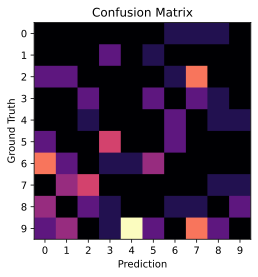

In [19]:
for i in range(10):
    matr[i][i] = 0
plt.xticks(range(10))
plt.yticks(range(10))
plt.xlabel('Prediction')
plt.ylabel('Ground Truth')
plt.title('Confusion Matrix')
plt.imshow(matr, cmap=cm.get_cmap('magma'))

## References

A lot of online resources guided us through the maze. The followings are the most helpful ones. After each reference also attached is what I feel the most important about the reference source.

1. [PyTorch Dataset Normalization - `torchvision.transforms.Normalize()`](https://deeplizard.com/learn/video/lu7TCu7HeYc)

  I turned to this website for help when I'm thinking about how to normalize the dataset. I guess there must be related utilities I can use in PyTorch, and this article guided me how should I perform the normalization, and why should we do this.


2. [AdaDelta Explained](https://www.paperswithcode.com/method/adadelta)

  When I'm wondering which optimizer function to use, scrolling through each type in PyTorch docs, a few functions were selected for test. After repetitve tests, AdaDelta outperforms the rest in fields of accuracy. This article shows how AdaDelta works and why it makes sense here in the task of MNIST.
